# Baseline 算法

动物分类教程

使用 Python 进行编程文档请参阅 https://docs.python.org/zh-cn/3/contents.html 。

使用 PyTorch 框架，下载、文档等详情参阅 https://pytorch.org/ ，具体中文文档参阅 https://www.pytorch.wiki/ 。

## 环境配置

在运行本代码前，你需要在以下选项二选一完成：本地环境配置或使用 Google Colab * <a href="https://colab.research.google.com/drive/1Lf0Y5-3gvjKKggQTf1zWrEqHYYIVp3z2#scrollTo=Omm0IoVSJ4Kw" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
完成。若你使用 Colab 可以忽略以下配置环境的过程，可直接阅读下一节。

建议你下载 Anaconda 完成虚拟环境的配置，https://www.anaconda.com ，因为在不同的项目中需要的 Python 版本、不同包的版本可能不同，因此需要不同包的管理软件。Anaconda 的使用，参阅 https://anaconda.cloud/support-center ，或 https://zhuanlan.zhihu.com/p/348120084 获得对新手更为友好的中文教程。

Colab 使用建议：你可以使用你的 Google Drive，将数据集上传至 Google Drive 后，进行挂载使用。否则需要每次会话时重复上传。Google Drive 挂载在 Colab 使用参阅 https://blog.csdn.net/aiynmimi/article/details/88238246

## 数据读入

如何读入数据？参阅 https://pytorch.org/tutorials/beginner/basics/data_tutorial.html ，我们进行对数据集的读入。
在真正读入前，我们先进行一些预处理。

In [2]:
NUM_CLASSES = 22
LABELS = [
    "ape", "bear", "bison", "cat", 
    "chicken", "cow", "deer", "dog",
    "dolphin", "duck", "eagle", "fish", 
    "horse", "lion", "lobster", "pig", 
    "rabbit", "shark", "snake", "spider", 
    "turkey", "wolf"
]
LABEL_MAP = {
    0: "ape", 1: "bear", 2: "bison", 3: "cat", 
    4: "chicken", 5: "cow", 6: "deer", 7: "dog",
    8: "dolphin", 9: "duck", 10: "eagle", 11: "fish", 
    12: "horse", 13: "lion", 14: "lobster", 
    15: "pig", 16: "rabbit", 17: "shark", 18: "snake", 
    19: "spider", 20:  "turkey", 21: "wolf"
}

你还需要把训练集进行分割，分割出 Valid 集

由于本任务数据的特殊性，可以直接使用 ImageFolder ，而不需要单独设计 Dataset 类，因此先定义 transformss, 参阅 https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html 。

In [3]:
from torchvision import transforms
import torch
train_transform = transforms.Compose(
    (
        transforms.RandomResizedCrop(176, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomHorizontalFlip(),
        transforms.autoaugment.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        transforms.RandomErasing(p=0.1),
        ))

test_transform = transforms.Compose((transforms.ToTensor(), transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR), transforms.CenterCrop(224), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])))


自定义VisionDataset子类

In [4]:
from torchvision.datasets import VisionDataset
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
from pathlib import Path
import re
class AnimalDataset(VisionDataset):
    def __init__(self, root: str, transforms: Optional[Callable] = None, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)
        data_path = Path(self.root)
        image_list = list(data_path.glob('*.png'))
        self.images = [str(i) for i in image_list]
    
    def __getitem__(self, index: int) -> Any:
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')  # 读取到的是RGB， W, H, C
        image = self.transforms(image)   # transform转化image为：C, H, W

        label = re.sub(r'\D', "", image_path)
        return image, int(label)
    
    def __len__(self) -> int:
        return len(self.images)
    

将训练、测试集读入 DataLoader

In [5]:
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_path = './Animals Dataset' #@param 
batch_size = 32 #@param
num_workers = 0 #@param

train_path = (os.path.join(data_path, 'train'))
test_path = (os.path.join(data_path, 'test'))
val_path = (os.path.join(data_path, 'val'))

train_dataset = ImageFolder(
    train_path,
    train_transform)
val_dataset = ImageFolder(
    val_path,
    test_transform)
test_dataset = AnimalDataset(
    test_path,
    test_transform)


随机挑选16张图片测试数据读入是否顺利

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

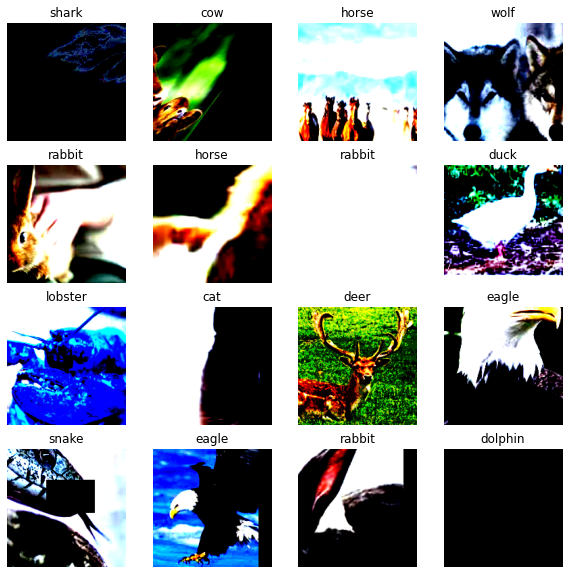

In [6]:
import matplotlib.pyplot as plt
from torch import randint
%matplotlib inline
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

## 建立模型

本节介绍如何定义一个模型，参阅 https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

先进行预处理

In [7]:
import torch
from torch import nn
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    num_workers=num_workers,
    shuffle=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=num_workers)

Using cuda device


定义模型类，注意到 PyTorch 是动态图，因此在数据进行前向传播时我们相当于已经定义了 Backpropagation 反向传播。

这样模型就可以定义为：

In [8]:
from torchvision import models
model = models.resnet50().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

设置模型训练超参数、损失函数与优化器

In [9]:
learning_rate = 1e-1  # @param
# batch_size = 32 #@param 此处貌似在DataLoader部分定义了
epochs = 600  # @param
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)
warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.001, total_iters=5)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs-5)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer, schedulers=[warmup_lr_scheduler, main_scheduler], milestones=[5])


定义评价指标

In [10]:
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
      self.name = name
      self.fmt = fmt
      self.reset()

  def reset(self):
      self.val = 0
      self.avg = 0
      self.sum = 0
      self.count = 0

  def update(self, val, n=1):
      self.val = val
      self.sum += val * n
      self.count += n
      self.avg = self.sum / self.count

  def __str__(self):
      fmtstr = '{name} {avg' + self.fmt + '}'
      return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

batch_time = AverageMeter('Time', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Training loss', ':.4e')
top1 = AverageMeter('Acc@1', ':6.2f')
top5 = AverageMeter('Acc@5', ':6.2f')

训练

In [11]:
import time

val_loss_history = []
loss_history = []
top1_history = []
top5_history = []
best_loss = 0x7fffffff

start = time.time()
for i in range(epochs):
  for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    data_time.update(time.time() - start)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  batch_time.update(time.time() - start)
  start = time.time()

  with torch.no_grad():
    for batch, (X, y) in enumerate(val_loader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      val_loss = loss_fn(pred, y)
      if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        best_epoch = i
        best_model = model
      acc1, acc5 = accuracy(pred, y, topk=(1, 5))
      loss_history.append(loss.item())
      val_loss_history.append(val_loss.item())
      top1_history.append(acc1[0])
      top5_history.append(acc5[0])
      losses.update(loss.item(), X.size(0))
      top1.update(acc1[0], X.size(0))
      top5.update(acc5[0], X.size(0))
    scheduler.step()
      
  print(f"Epoch:{i + 1}: {batch_time}, {losses}, Validation loss {val_loss.item():.4e}, {top1}, {top5}, learning rate {optimizer.state_dict()['param_groups'][0]['lr']}")
  losses.reset()
  top1.reset()
  top5.reset()

print(f"Best Epoch:{best_epoch + 1}, loss: {best_loss}, Acc@1: {top1_history[best_epoch]}, Acc@5: {top5_history[best_epoch]}")


Epoch:1: Time 15.911, Training loss 4.4112e+00, Validation loss 4.3671e+00, Acc@1   6.16, Acc@5  25.00, learning rate 0.02008
Epoch:2: Time 14.293, Training loss 6.4967e+00, Validation loss 4.9460e+00, Acc@1   7.53, Acc@5  28.42, learning rate 0.04006
Epoch:3: Time 13.639, Training loss 3.1849e+00, Validation loss 3.2086e+00, Acc@1   4.45, Acc@5  33.90, learning rate 0.060039999999999996
Epoch:4: Time 13.410, Training loss 2.8849e+00, Validation loss 3.1210e+00, Acc@1  11.64, Acc@5  39.38, learning rate 0.08002


/home/nightingalecen/miniconda3/envs/LearningDeep/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:5: Time 13.316, Training loss 2.9800e+00, Validation loss 2.8916e+00, Acc@1  14.73, Acc@5  46.58, learning rate 0.1
Epoch:6: Time 13.242, Training loss 3.0500e+00, Validation loss 3.2157e+00, Acc@1  10.27, Acc@5  40.41, learning rate 0.09999930304487875
Epoch:7: Time 13.194, Training loss 2.9289e+00, Validation loss 2.9641e+00, Acc@1  10.62, Acc@5  45.21, learning rate 0.09999721219894483
Epoch:8: Time 13.176, Training loss 2.9834e+00, Validation loss 3.1998e+00, Acc@1  12.67, Acc@5  43.49, learning rate 0.0999937275204873
Epoch:9: Time 13.156, Training loss 2.9718e+00, Validation loss 3.4300e+00, Acc@1  11.99, Acc@5  46.23, learning rate 0.09998884910665269
Epoch:10: Time 13.137, Training loss 2.8737e+00, Validation loss 3.0162e+00, Acc@1  16.10, Acc@5  53.42, learning rate 0.09998257709344248
Epoch:11: Time 13.118, Training loss 2.7085e+00, Validation loss 2.7802e+00, Acc@1  14.38, Acc@5  45.21, learning rate 0.09997491165570908
Epoch:12: Time 13.102, Training loss 3.1092e+00, 

Epoch:65: Time 13.032, Training loss 2.5505e+00, Validation loss 2.1201e+00, Acc@1  40.07, Acc@5  74.66, learning rate 0.09751187000305075
Epoch:66: Time 13.030, Training loss 2.4137e+00, Validation loss 2.1706e+00, Acc@1  36.99, Acc@5  74.32, learning rate 0.09742896525642443
Epoch:67: Time 13.028, Training loss 1.9908e+00, Validation loss 2.1165e+00, Acc@1  36.64, Acc@5  73.63, learning rate 0.09734473827538882
Epoch:68: Time 13.026, Training loss 2.3014e+00, Validation loss 2.0785e+00, Acc@1  38.36, Acc@5  74.32, learning rate 0.097259191408041
Epoch:69: Time 13.026, Training loss 2.6028e+00, Validation loss 2.1269e+00, Acc@1  35.62, Acc@5  73.63, learning rate 0.09717232703927403
Epoch:70: Time 13.025, Training loss 2.2083e+00, Validation loss 2.0684e+00, Acc@1  43.15, Acc@5  78.77, learning rate 0.0970841475907106
Epoch:71: Time 13.024, Training loss 2.2635e+00, Validation loss 2.0774e+00, Acc@1  41.10, Acc@5  74.66, learning rate 0.09699465552063542
Epoch:72: Time 13.024, Trainin

Epoch:124: Time 13.001, Training loss 2.2217e+00, Validation loss 1.5981e+00, Acc@1  54.79, Acc@5  86.30, learning rate 0.09045084971874738
Epoch:125: Time 12.999, Training loss 1.6908e+00, Validation loss 1.5350e+00, Acc@1  55.14, Acc@5  87.33, learning rate 0.09029511164747175
Epoch:126: Time 12.997, Training loss 1.5214e+00, Validation loss 1.5942e+00, Acc@1  51.71, Acc@5  85.62, learning rate 0.09013825022081914
Epoch:127: Time 12.997, Training loss 1.8232e+00, Validation loss 1.5611e+00, Acc@1  52.40, Acc@5  85.62, learning rate 0.08998026981180454
Epoch:128: Time 12.998, Training loss 1.5395e+00, Validation loss 1.5713e+00, Acc@1  53.42, Acc@5  85.27, learning rate 0.08982117482463817
Epoch:129: Time 12.998, Training loss 1.5680e+00, Validation loss 1.4066e+00, Acc@1  56.51, Acc@5  89.04, learning rate 0.08966096969460265
Epoch:130: Time 12.997, Training loss 1.6636e+00, Validation loss 1.5169e+00, Acc@1  54.11, Acc@5  85.96, learning rate 0.0894996588879294
Epoch:131: Time 12.99

Epoch:183: Time 12.980, Training loss 1.0728e+00, Validation loss 1.3723e+00, Acc@1  58.22, Acc@5  86.64, learning rate 0.07949595006894915
Epoch:184: Time 12.980, Training loss 1.5228e+00, Validation loss 1.3875e+00, Acc@1  57.19, Acc@5  88.01, learning rate 0.07928237032997035
Epoch:185: Time 12.981, Training loss 1.6814e+00, Validation loss 1.3936e+00, Acc@1  56.85, Acc@5  85.96, learning rate 0.07906797425107298
Epoch:186: Time 12.981, Training loss 1.7253e+00, Validation loss 1.2712e+00, Acc@1  60.96, Acc@5  89.38, learning rate 0.07885276780923485
Epoch:187: Time 12.980, Training loss 1.6886e+00, Validation loss 1.3838e+00, Acc@1  61.64, Acc@5  87.33, learning rate 0.07863675700402524
Epoch:188: Time 12.979, Training loss 1.4378e+00, Validation loss 1.3379e+00, Acc@1  59.59, Acc@5  88.36, learning rate 0.07841994785743762
Epoch:189: Time 12.977, Training loss 1.6986e+00, Validation loss 1.3274e+00, Acc@1  57.19, Acc@5  89.04, learning rate 0.0782023464137218
Epoch:190: Time 12.97

Epoch:242: Time 12.994, Training loss 7.2538e-01, Validation loss 1.2038e+00, Acc@1  66.44, Acc@5  90.07, learning rate 0.06570171151433883
Epoch:243: Time 12.993, Training loss 9.5645e-01, Validation loss 1.2874e+00, Acc@1  66.44, Acc@5  89.04, learning rate 0.06545084971874733
Epoch:244: Time 12.993, Training loss 1.2286e+00, Validation loss 1.2896e+00, Acc@1  61.64, Acc@5  87.67, learning rate 0.06519955718120228
Epoch:245: Time 12.993, Training loss 1.4664e+00, Validation loss 1.2782e+00, Acc@1  61.64, Acc@5  87.33, learning rate 0.0649478409072885
Epoch:246: Time 12.993, Training loss 6.7410e-01, Validation loss 1.2584e+00, Acc@1  63.36, Acc@5  89.73, learning rate 0.06469570791440381
Epoch:247: Time 12.993, Training loss 9.3445e-01, Validation loss 1.2446e+00, Acc@1  64.73, Acc@5  90.07, learning rate 0.06444316523156346
Epoch:248: Time 12.994, Training loss 1.1028e+00, Validation loss 1.2872e+00, Acc@1  64.38, Acc@5  88.36, learning rate 0.06419021989920412
Epoch:249: Time 12.99

Epoch:301: Time 12.987, Training loss 1.3499e+00, Validation loss 1.2743e+00, Acc@1  63.70, Acc@5  91.78, learning rate 0.050395994934081534
Epoch:302: Time 12.987, Training loss 9.9024e-01, Validation loss 1.2258e+00, Acc@1  64.04, Acc@5  89.04, learning rate 0.05013199953799723
Epoch:303: Time 12.987, Training loss 1.0482e+00, Validation loss 1.1604e+00, Acc@1  66.44, Acc@5  89.73, learning rate 0.04986800046200277
Epoch:304: Time 12.988, Training loss 7.4533e-01, Validation loss 1.1663e+00, Acc@1  65.07, Acc@5  91.78, learning rate 0.049604005065918465
Epoch:305: Time 12.988, Training loss 7.2663e-01, Validation loss 1.1797e+00, Acc@1  66.44, Acc@5  91.78, learning rate 0.04934002070946206
Epoch:306: Time 12.988, Training loss 8.7118e-01, Validation loss 1.2909e+00, Acc@1  63.70, Acc@5  89.38, learning rate 0.04907605475204351
Epoch:307: Time 12.989, Training loss 8.5659e-01, Validation loss 1.3051e+00, Acc@1  61.64, Acc@5  88.01, learning rate 0.048812114552559856
Epoch:308: Time 1

Epoch:360: Time 12.979, Training loss 4.7880e-01, Validation loss 1.1372e+00, Acc@1  65.07, Acc@5  91.78, learning rate 0.03505215909271147
Epoch:361: Time 12.978, Training loss 6.2137e-01, Validation loss 1.0708e+00, Acc@1  67.12, Acc@5  91.10, learning rate 0.03480044281879767
Epoch:362: Time 12.978, Training loss 6.5014e-01, Validation loss 1.0688e+00, Acc@1  65.07, Acc@5  91.78, learning rate 0.03454915028125261
Epoch:363: Time 12.978, Training loss 4.0327e-01, Validation loss 1.1228e+00, Acc@1  67.47, Acc@5  92.12, learning rate 0.03429828848566112
Epoch:364: Time 12.977, Training loss 9.9641e-01, Validation loss 1.1287e+00, Acc@1  67.47, Acc@5  90.75, learning rate 0.03404786442559974
Epoch:365: Time 12.977, Training loss 4.8408e-01, Validation loss 1.1565e+00, Acc@1  64.73, Acc@5  92.12, learning rate 0.033797885082441685
Epoch:366: Time 12.978, Training loss 8.9651e-01, Validation loss 1.1670e+00, Acc@1  67.12, Acc@5  90.07, learning rate 0.03354835742516232
Epoch:367: Time 12.

Epoch:419: Time 13.069, Training loss 5.0355e-01, Validation loss 1.0799e+00, Acc@1  69.86, Acc@5  90.07, learning rate 0.021147232190765128
Epoch:420: Time 13.070, Training loss 2.7083e-01, Validation loss 1.0261e+00, Acc@1  71.92, Acc@5  90.75, learning rate 0.020932025748927004
Epoch:421: Time 13.070, Training loss 3.5617e-01, Validation loss 1.0140e+00, Acc@1  69.18, Acc@5  91.78, learning rate 0.02071762967002962
Epoch:422: Time 13.070, Training loss 7.5015e-01, Validation loss 1.0662e+00, Acc@1  68.49, Acc@5  92.81, learning rate 0.020504049931050823
Epoch:423: Time 13.071, Training loss 5.0153e-01, Validation loss 1.1075e+00, Acc@1  68.49, Acc@5  92.81, learning rate 0.0202912924862103
Epoch:424: Time 13.071, Training loss 3.9796e-01, Validation loss 1.0786e+00, Acc@1  68.15, Acc@5  91.44, learning rate 0.020079363266803686
Epoch:425: Time 13.073, Training loss 5.4619e-01, Validation loss 1.0931e+00, Acc@1  67.81, Acc@5  91.10, learning rate 0.019868268181037176
Epoch:426: Time 

Epoch:478: Time 13.097, Training loss 4.5607e-01, Validation loss 1.0516e+00, Acc@1  70.89, Acc@5  90.41, learning rate 0.010019730188195448
Epoch:479: Time 13.097, Training loss 9.0381e-02, Validation loss 1.0252e+00, Acc@1  70.55, Acc@5  91.10, learning rate 0.009861749779180869
Epoch:480: Time 13.097, Training loss 4.4856e-01, Validation loss 1.0887e+00, Acc@1  68.49, Acc@5  91.44, learning rate 0.009704888352528253
Epoch:481: Time 13.097, Training loss 5.2949e-01, Validation loss 1.0761e+00, Acc@1  68.84, Acc@5  91.10, learning rate 0.00954915028125263
Epoch:482: Time 13.098, Training loss 2.8423e-01, Validation loss 1.0538e+00, Acc@1  68.84, Acc@5  92.12, learning rate 0.009394539907051833
Epoch:483: Time 13.099, Training loss 3.2486e-01, Validation loss 1.0280e+00, Acc@1  69.18, Acc@5  91.44, learning rate 0.009241061540185556
Epoch:484: Time 13.102, Training loss 3.2315e-01, Validation loss 9.9372e-01, Acc@1  73.63, Acc@5  91.44, learning rate 0.00908871945935513
Epoch:485: Time

Epoch:537: Time 13.172, Training loss 7.0475e-01, Validation loss 9.8882e-01, Acc@1  71.58, Acc@5  92.47, learning rate 0.0027408085919590256
Epoch:538: Time 13.173, Training loss 4.9414e-01, Validation loss 9.6903e-01, Acc@1  71.23, Acc@5  92.12, learning rate 0.0026552617246111956
Epoch:539: Time 13.174, Training loss 4.1562e-01, Validation loss 9.6986e-01, Acc@1  72.26, Acc@5  92.47, learning rate 0.0025710347435755946
Epoch:540: Time 13.174, Training loss 6.0501e-01, Validation loss 9.7741e-01, Acc@1  71.58, Acc@5  92.47, learning rate 0.00248812999694925
Epoch:541: Time 13.175, Training loss 6.2290e-01, Validation loss 9.6515e-01, Acc@1  71.23, Acc@5  92.47, learning rate 0.002406549795967682
Epoch:542: Time 13.176, Training loss 4.7015e-01, Validation loss 9.7364e-01, Acc@1  70.55, Acc@5  92.47, learning rate 0.0023262964149404312
Epoch:543: Time 13.177, Training loss 6.3944e-01, Validation loss 9.7115e-01, Acc@1  70.55, Acc@5  92.81, learning rate 0.002247372091187704
Epoch:544:

Epoch:595: Time 13.191, Training loss 3.3253e-01, Validation loss 9.9164e-01, Acc@1  70.21, Acc@5  91.10, learning rate 1.7422906557557078e-05
Epoch:596: Time 13.191, Training loss 4.3264e-01, Validation loss 9.9155e-01, Acc@1  70.21, Acc@5  91.10, learning rate 1.115089334732811e-05
Epoch:597: Time 13.191, Training loss 3.5443e-01, Validation loss 9.9150e-01, Acc@1  70.21, Acc@5  91.10, learning rate 6.272479512731135e-06
Epoch:598: Time 13.191, Training loss 2.3819e-01, Validation loss 9.9147e-01, Acc@1  70.21, Acc@5  91.10, learning rate 2.787801055181839e-06
Epoch:599: Time 13.191, Training loss 1.9581e-01, Validation loss 9.9146e-01, Acc@1  70.21, Acc@5  91.10, learning rate 6.969551212598905e-07
Epoch:600: Time 13.191, Training loss 1.5796e-01, Validation loss 9.9146e-01, Acc@1  70.21, Acc@5  91.10, learning rate 0.0
Best Epoch:504, loss: 0.9347909092903137, Acc@1: 72.60273742675781, Acc@5: 92.46575164794922


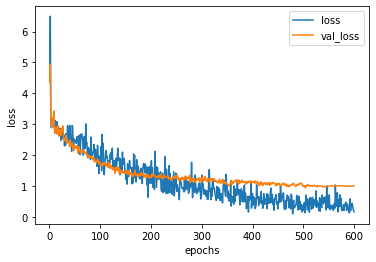

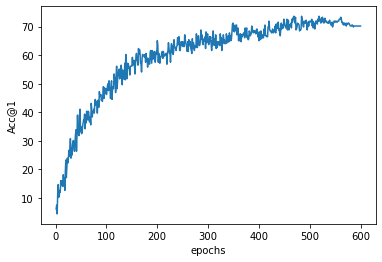

<Figure size 432x288 with 0 Axes>

In [12]:
import numpy as np
plt.plot(np.arange(1, epochs+1), loss_history, label="loss")
plt.plot(np.arange(1, epochs+1), val_loss_history, label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
#plt.savefig("loss.png")
plt.show()
plt.clf()
plt.plot(np.arange(1, epochs+1), [i.item() for i in top1_history])
plt.xlabel("epochs")
plt.ylabel("Acc@1")
#plt.savefig("Acc.png")
plt.show()
plt.clf()

由于模型过于简单，因此训练准确率不高。你可以尝试训练其它的模型（甚至于预训练模型，但预训练模型如何进行训练也是一个值得讨论的问题）。
同时，这里并没有使用 Valid 集来进行评价，而是使用了 train 集，你可以尝试加入 Valid 集（如提前分割，或用其他方式等）



# 输出结果

输出结果非常简单，与训练类似，但模型不能更新参数

In [13]:
#model = torch.load('./ResNet34_8.30_1700.pt')

In [14]:
import numpy as np
def test(model, test_image, name_prefix):
  model.eval()
  labels = []
  image_numbers = []
  with torch.no_grad():
    for _, (images, label) in enumerate(test_image):
      images = images.to(device)
      y = model(images)
      batch_labels = torch.argmax(y, dim=1)
      labels.append(batch_labels)
      image_numbers.append(label)
  ans = torch.cat(labels, 0).cpu().numpy()
  image_numbers = torch.cat(image_numbers, 0).cpu().numpy()
  res = {image_numbers[i]:LABEL_MAP[j] for i, j in enumerate(ans)}
  print(f"{name_prefix} model result:", res)
  return res

res = test(best_model, test_loader, "best")



best model result: {0: 'horse', 1: 'duck', 10: 'deer', 100: 'chicken', 101: 'horse', 102: 'pig', 103: 'cat', 104: 'bear', 105: 'lobster', 106: 'pig', 107: 'eagle', 108: 'bison', 109: 'pig', 11: 'cat', 12: 'ape', 13: 'fish', 14: 'turkey', 15: 'dog', 16: 'chicken', 17: 'horse', 18: 'horse', 2: 'dog', 20: 'duck', 21: 'turkey', 22: 'shark', 23: 'dolphin', 24: 'bear', 25: 'duck', 26: 'dog', 27: 'pig', 28: 'lion', 29: 'chicken', 3: 'dog', 30: 'duck', 31: 'shark', 32: 'chicken', 33: 'cat', 34: 'snake', 35: 'deer', 36: 'lobster', 37: 'ape', 38: 'lion', 4: 'cow', 40: 'horse', 41: 'lobster', 42: 'eagle', 43: 'snake', 44: 'spider', 45: 'eagle', 46: 'rabbit', 47: 'wolf', 48: 'wolf', 49: 'lobster', 5: 'fish', 50: 'shark', 51: 'lobster', 52: 'chicken', 53: 'bison', 54: 'dolphin', 55: 'spider', 56: 'cow', 57: 'shark', 58: 'dog', 6: 'turkey', 60: 'duck', 61: 'bear', 62: 'spider', 63: 'duck', 64: 'snake', 65: 'deer', 66: 'lobster', 67: 'ape', 68: 'dolphin', 69: 'deer', 7: 'cow', 70: 'bison', 71: 'ape',

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

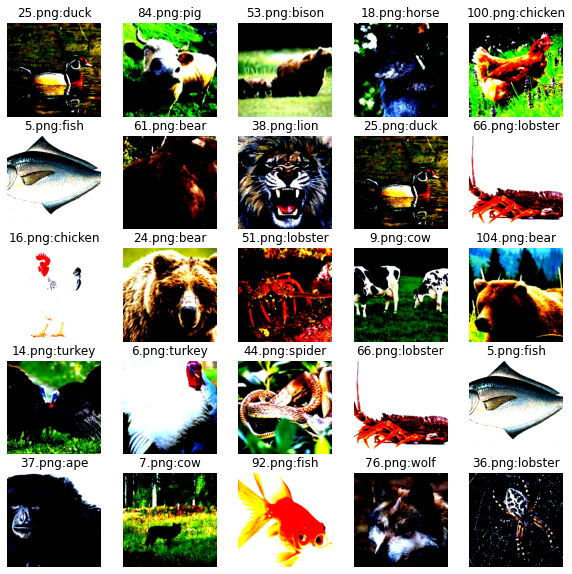

In [22]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(test_dataset), size=(1,)).item()
    img, num = test_dataset[sample_idx]
    label = res[num]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{num}.png:{label}")
    plt.axis("off")
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img.squeeze())
plt.show()

# 保存模型

参阅 https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [16]:
#网络_日期_时间.pt
import time
t = time.localtime(time.time())
torch.save(best_model, f'./ResNet50_{t[1]}.{t[2]}_{t[3]}{t[4]}.pt')

In [17]:
#model = torch.load('model.path')